<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻 01 - Pinhole camera model

A *pinhole camera* is perhaps the simplest representation of how cameras, including those used on the Duckiebot, produce images of the scene by recording levels of incident light that reflect off objects in the scene and strike the sensor. The *ideal* pinhole camera treats the aperture as being a point, however most cameras couple wider apertures that allow more light to pass through with lenses that focus reflected light. Coupled with models of lens distortion, many cameras used in practice can be modeled as a pihnole camera.

<figure>
  <div style="text-align:center;">
  <img src="../images/pinhole_camera_model/duckie-pinhole.png", width=500px>
  <figcaption>A visualization of a simple pinhole camera.</figcaption>
  </div>
</figure>

The *pinhole camera model* is a mathematical model that describes the projection of a point in a three-dimensional space onto a two-dimensional image plane by an *ideal* pinhole camera, according to perspective projection. Consider a three-dimensional Cartesian reference frame with its origin at the camera (optical) center $C$ and the positive $Z$-axis pointing out of the camera. The $Z$-axis is referred to as the *principal axis*. The two-dimensional image plane is perpendicular to principal axis and located at a distance $f$ behind the camera center (i.e., $z=-f$), where the parameter $f$ is the focal length. In order to avoid dealing with inverted images, we can treat the image plane as being in the positive $Z$-direction, again at a distance $f$ from the camera center.

<figure>
  <div style="text-align:center;">
  <img src="../images/pinhole_camera_model/pinhole-projection-a.png", width=500px>
  <figcaption>Pinhole camera geometry.</figcaption>
  </div>
</figure>

Consider a point in the reference frame of the camera defined in terms of its Cartesian coordinates $\tilde{\mathbf{X}}_\textrm{cam} = [x \; y \; z]^\top$. We can express this point in *homogeneous coordinates* via the 4-vector, $\mathbf{X}_\textrm{cam} = [x \; y \; z\; 1]^\top$. For those who may not be familiar with homogeneous coordinates, we can express the coordinates of a point that we would typically represent in Cartesian coordinates as $\tilde{\mathbf{X}} = [X \; Y \; Z]^\top$, in terms of $\mathbf{X} = [X \; Y \; Z \; 1]^\top$, where we append a $1$ at the end. Thus, for any non-zero scalar $\alpha$, the homogeneous coordinates $[\alpha X \; \alpha Y \; \alpha]$ define the same Cartesian coordinates $X, Y$. Transferring a point from homogeneous to Cartesian coordinates involves dividing by the last element of the homogeneous coordinate vector ($1$ in this case) and keeping all but the last entry. Consequently, multiplying the homogeneous vector we can use the homogeneous coordinates $[\alpha u \; \alpha v \; \alpha]$ to represent the Cartesian coordinates $\begin{bmatrix} u \; v \end{bmatrix}$.

Returning to the camera projection, we can relate the vector $\mathbf{X}_\textrm{cam}$ to its projection onto the image $\mathbf{x}$, expressed in terms of its homogeneous 3-vector as

$$ 
\begin{align}
\begin{bmatrix}
fx\\
fy\\
z
\end{bmatrix} &=
\begin{bmatrix}
f & 0 & 0 & 0\\
0 & f & 0 & 0\\
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
z\\
1
\end{bmatrix}\\
\mathbf{x} &= P \mathbf{X}_\textrm{cam}
\end{align}
$$

where $P$ is the homogeneous *camera projection matrix*.

Thus far, we have assumed that the origin in the image coordinates is at the principal point $\textbf{p}$, which is the point at which the principal axis intersects the image plane. In practice, the origin may be located elsewhere and the principal point will have coordinates $[p_x \; p_y]$. Meanwhile, digital cameras may include pixels that are not square, which is sometimes represented as focal lengths $(f_x, f_y)$ that differ in the two image-space directions. Together, this gives rise to a more general expression for the camera matrix:

$$ 
\mathbf{x} = 
\begin{bmatrix}
f_x x + p_x z\\
f_y y + p_y z\\
z
\end{bmatrix} =
\begin{bmatrix}
f_x & 0 & p_x & 0\\
0 & f_y & p_y & 0\\
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
z\\
1
\end{bmatrix}
$$

We can express this as 

$$
\mathbf{x} = K [I \; \vert \; \mathbf{0}]\mathbf{X}_\textrm{cam} \qquad 
K = 
\begin{bmatrix}
f_x & s & p_x\\
0 & f_y & p_y\\
0 & 0 & 1
\end{bmatrix}
$$

where $K$ is the *camera calibration matrix*, $I$ is a $3 \times 3$ identity matrix, and $\mathbf{0}$ is a three-vector of zeros. **Note**: in the intrinsic matrix above, we have introduced an additional *skew* parameter $s$ that represents shear. Oftentimes, the skew is (near-)zero, however we will include it in the intrinsic matrix in the remainder of the exercise for generality.

In [3]:
### Run this cell to initialize the problem


%matplotlib inline
import numpy as np
import matplotlib.pyplot as  plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
class CameraProjection:
    def __init__(self, width, height, f):
        self._fig = plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
        self._ax = self._fig.add_subplot(111, projection='3d')
        
        # Coordinates are changed for visualization
        # x --> z, y --> x, z --> y
        self._ax.set_xlim(0, 4)
        self._ax.set_ylim(-(width/2 + 1), width/2 + 1)
        self._ax.set_zlim(-(height/2 + 1), height/2 + 1)
        self._ax.view_init(elev=15, azim=-75)
        self._width = width
        self._height = height
        self._f = f
        self._K = np.array([[f, 0, 0, 0],[0, f, 0, 0],[0, 0, 1, 0]])
        self._R = np.array([[0, 0, 1],[1, 0, 0], [0, 1, 0]])
    def transform(self, x):
        return self._R.dot(x)
    def transform(self, x, y, z):
        X = np.array([[x, y, z]]).transpose()
        return self._R.dot(X)
    def drawCameraModel(self):
        length = np.minimum(self._width, self._height)/2
        arrow_prop_dict = dict(mutation_scale=20, arrowstyle='->', shrinkA=0, shrinkB=0)
        a = Arrow3D([0, 0], [0, length], [0, 0], **arrow_prop_dict, color='r')
        self._ax.add_artist(a)
        a = Arrow3D([0, 0], [0, 0], [0, length], **arrow_prop_dict, color='g')
        self._ax.add_artist(a)
        a = Arrow3D([0, self._f*4], [0, 0], [0, 0], **arrow_prop_dict, color='b')
        self._ax.add_artist(a)
        
        # Image plane
        x = [self._width/2, self._width/2, -self._width/2, -self._width/2, self._width/2]
        y = [-self._height/2, self._height/2, self._height/2, -self._height/2, -self._height/2]
        z = [self._f, self._f, self._f, self._f, self._f]
        self._ax.plot(z, x, y)
        self._ax.plot([self._f], [0], [0], 'b.', markersize=12)
    def drawProjection(self, Xtilde):
        cam.drawCameraModel()
        X = np.vstack((Xtilde, 1))
        Xtransform =self._R.dot(X[0:3])
        x = self._K.dot(X)
        xtilde = np.vstack((x[0:2]/x[-1],self._f))
        xtransform = self._R.dot(xtilde)
        self._ax.set_xlim(0, Xtransform[0] + 2)
        ydim = np.array([width/2, np.abs(Xtilde[0])]).max()
        self._ax.set_ylim(-ydim - 1, ydim + 1)
        zdim = np.array([height/2, np.abs(Xtilde[1])]).max()
        self._ax.set_zlim(-zdim - 1, zdim + 1)
        
        self._ax.plot3D(xtransform[0], xtransform[1], xtransform[2],'r.', markersize=12)
        self._ax.plot3D(Xtransform[0], Xtransform[1], Xtransform[2],'r.', markersize=12)
        self._ax.plot3D([0, Xtransform[0]], [0,Xtransform[1]], [0,  Xtransform[2]],'k--')
        self._ax.plot3D(xtransform[0], xtransform[1], xtransform[2],'r.', markersize=12)
        self._ax.plot3D(Xtransform[0], Xtransform[1], Xtransform[2],'r.', markersize=12)
        plt.show()

### Example: Camera projection

In this example, you will experiment with the effect of changing the focal length of the camera. For our purposes, we will assume that the focal lengths in the $x$ and $y$ directions are the same, i.e., $f_x = f_y = f$.

The following code will render the projection of scene point in the camera's reference frame ($\tilde X$) on to an image of size `width` $\times$ `height`, with the specified focal length. If you increase the focal length, what happens to the distance between the projected point and the principal point? 

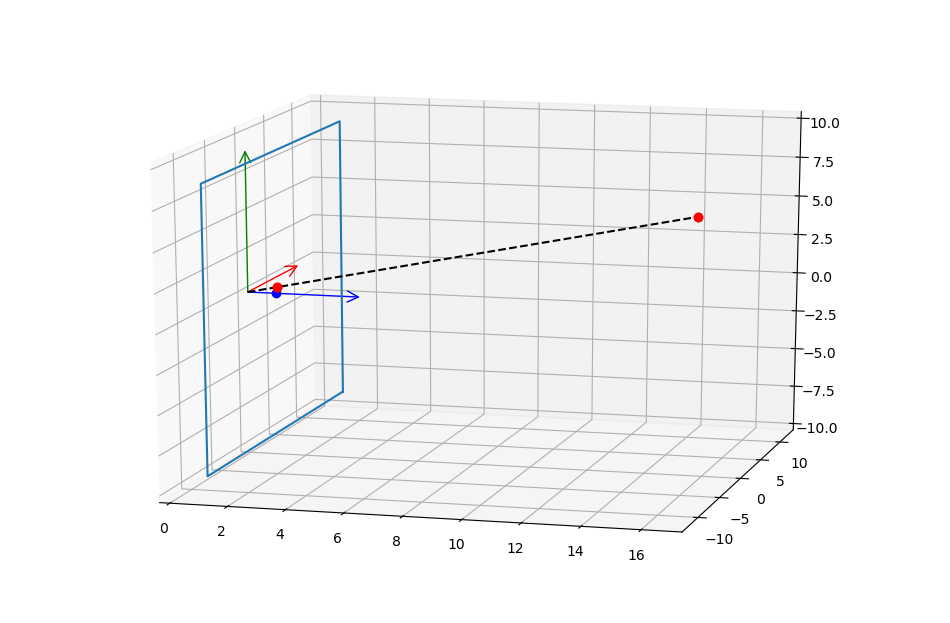

In [7]:
width = 24                       # The width of the image
height = 18                      # The height of the image
f = 1                            # The focal length
Xtilde = np.array([[5, 5, 15]])  # The Cartesian coordinates of the scene point


cam = CameraProjection(width, height, f)
cam.drawProjection(Xtilde.transpose())

In many cases, we are interested in the model that describes how points defined with respect to a reference frame differe from that of the camera (e.g., a fixed world coordinate system or the robot's body-fixed reference frame). As we saw previously, we can transform points between different reference frames based on the $3 \times 3$ rotation matrix $R$ and the three-element translation vector $\mathbf{t}$.

<figure>
  <div style="text-align:center;">
  <img src="../images/pinhole_camera_model/pinhole-projection-b.png", width="600px" />
  <figcaption>Points expressed in a reference frame other than that of the camera are first transformed into the camera's reference frame before being projected onto the image.</figcaption>
  </div>
</figure>

Consider a scene point $\tilde{\mathbf{X}}_w$ represented by its non-homogeneous coordinates with respect to a fixed Cartesian coordinate frame. Let $R$ be the rotation matrix from the world coordinate frame to the camera's coordinate frame, and let $\mathbf{t}$ be the translation vector from the world frame to the camera frame (i.e., the origin of the world frame expressed in the camera's reference frame). We can express the Cartesian coordinates of the scene point with respect to the camera's coordinate frame as

$$\tilde{\mathbf{X}}_\textrm{cam} = R\tilde{\mathbf{X}}_w + \mathbf{t}$$

In terms of homogeneous coordinates, this becomes

$$\mathbf{X}_\textrm{cam} = 
\begin{bmatrix}
R\tilde{\mathbf{X}}_w + \mathbf{t}\\
1
\end{bmatrix}
$$

Revisiting the expression for the camera matrix above, we can now include the transformation from the world coordinate frame to the camera's coordinate frame in our pinhole camera model

$$
\begin{align}
\mathbf{x} &= K [I \; \vert \; \mathbf{0}]\mathbf{X}_\textrm{cam}\\
           &= K [I \; \vert \; \mathbf{0}] \begin{bmatrix}
R\tilde{\mathbf{X}}_w + \mathbf{t}\\
1
\end{bmatrix}\\
&= K [R \; \vert \; \mathbf{t}] \mathbf{X}_w
\end{align}
$$

The first matrix $K$ is is referred to as the *intrinsic matrix*, since it includes parameters that are specific (i.e., "intrinsic") to the camera, irrespective of where the camera is in the world. The second matrix, which defines the coordinate transformation from the world frame to the camera frame, is referred to as the *extrinsic* matrix, since the transformation does not depend on the specific camera (i.e., the paramters are "external" to the particular choice of camera).

You can now move to the [homographies tutorial](../02-Homographies/homographies.ipynb).